/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Total Reward: 12.0
Episode 2, Total Reward: 12.0
Episode 3, Total Reward: 10.0
Episode 4, Total Reward: 8.0
Episode 5, Total Reward: 14.0
Episode 6, Total Reward: 29.0
Episode 7, Total Reward: 9.0
Episode 8, Total Reward: 28.0
Episode 9, Total Reward: 14.0
Episode 10, Total Reward: 21.0
Episode 11, Total Reward: 14.0
Episode 12, Total Reward: 40.0
Episode 13, Total Reward: 14.0
Episode 14, Total Reward: 17.0
Episode 15, Total Reward: 31.0
Episode 16, Total Reward: 16.0
Episode 17, Total Reward: 15.0
Episode 18, Total Reward: 29.0
Episode 19, Total Reward: 33.0
Episode 20, Total Reward: 11.0
Episode 21, Total Reward: 11.0
Episode 22, Total Reward: 29.0
Episode 23, Total Reward: 24.0
Episode 24, Total Reward: 16.0
Episode 25, Total Reward: 12.0
Episode 26, Total Reward: 10.0
Episode 27, Total Reward: 15.0
Episode 28, Total Reward: 30.0
Episode 29, Total Reward: 14.0
Episode 30, Total Reward: 12.0
Episode 31, Total Reward: 30.0
Episode 32, Total Reward: 19.0
Episode 33, Total R

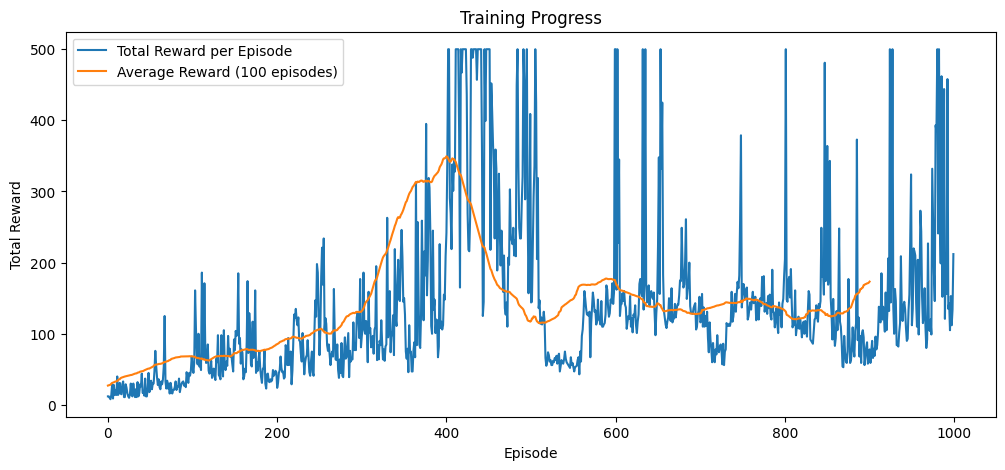

Average Reward over 10 episodes: 143.0


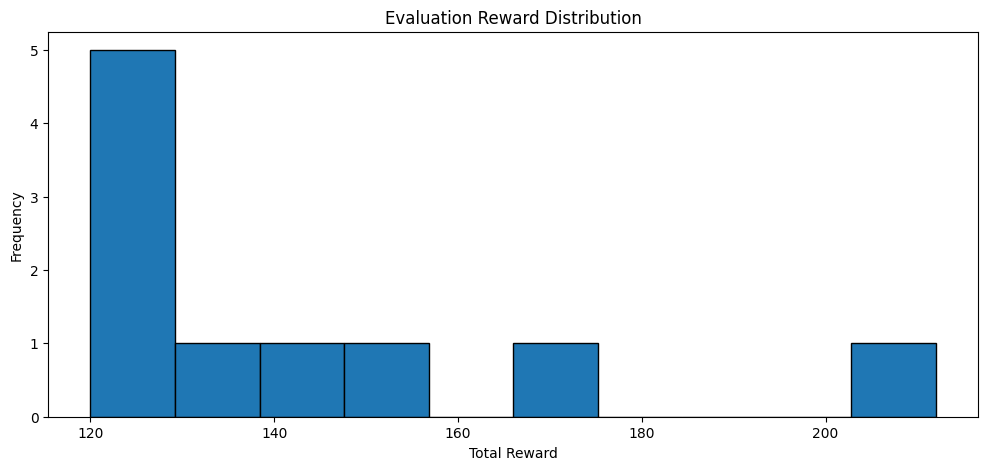

143.0

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ActorNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

class CriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ActorCriticAgent:
    def __init__(self, env, gamma=0.99, lr=0.001):
        self.env = env
        self.gamma = gamma

        self.actor = ActorNetwork(env.observation_space.shape[0], env.action_space.n)
        self.critic = CriticNetwork(env.observation_space.shape[0])

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr)

        self.criterion = nn.MSELoss()

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float)
        probabilities = self.actor(state)
        action = torch.multinomial(probabilities, 1).item()
        return action

    def update(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.int)

        # Critic update
        value = self.critic(state)
        next_value = self.critic(next_state)
        target = reward + self.gamma * next_value * (1 - int(done))
        loss_critic = self.criterion(value, target)

        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()

        # Actor update
        advantage = (target - value).detach()
        log_prob = torch.log(self.actor(state)[action])
        loss_actor = -log_prob * advantage

        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

    def train(self, max_episodes=1000):
        rewards = []
        for episode in range(max_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

            rewards.append(total_reward)
            print(f'Episode {episode + 1}, Total Reward: {total_reward}')

        # Plotting the rewards
        plt.figure(figsize=(12, 5))
        plt.plot(rewards, label='Total Reward per Episode')
        plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), label='Average Reward (100 episodes)')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.legend()
        plt.show()

    def evaluate(self, episodes=10):
        total_rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
            total_rewards.append(total_reward)

        average_reward = np.mean(total_rewards)
        print(f'Average Reward over {episodes} episodes: {average_reward}')

        # Plotting the evaluation rewards
        plt.figure(figsize=(12, 5))
        plt.hist(total_rewards, bins=10, edgecolor='black')
        plt.xlabel('Total Reward')
        plt.ylabel('Frequency')
        plt.title('Evaluation Reward Distribution')
        plt.show()

        return average_reward

# Create environment
env = gym.make('CartPole-v1')

# Initialize agent
agent = ActorCriticAgent(env)

# Train agent
agent.train(max_episodes=1000)

# Evaluate agent
agent.evaluate(episodes=10)
